In [35]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.optimize import curve_fit
import os
from tqdm.notebook import tqdm
import matplotlib.style as mplstyle
mplstyle.use('fast')

In [36]:
#check current working directory
retval = os.getcwd()
print ("Current working directory %s" %retval)

Current working directory C:\Users\megas\Documents\Cal\NEFall2022\NE204


In [37]:
# change directory
os.chdir(r'C:\Users\megas\Documents\Cal\NEFall2022\NE204')

#check current working directory
retwal = os.getcwd()
print ("Current working directory %s" %retval)

Current working directory C:\Users\megas\Documents\Cal\NEFall2022\NE204


In [56]:
#Input the data file and find the keys
f = h5py.File(r"C:\Users\megas\Documents\Cal\NEFall2022\Detectors204\lab1\9.12.22_HPGeData\Cs137-1min_10.h5", 'r')

#print the keys for the file path
print(f.keys())
print(f['raw_data'])

<KeysViewHDF5 ['event_data', 'raw_data']>
<HDF5 dataset "raw_data": shape (10131, 62500), type "<u2">


In [57]:
type(f['raw_data'])

h5py._hl.dataset.Dataset

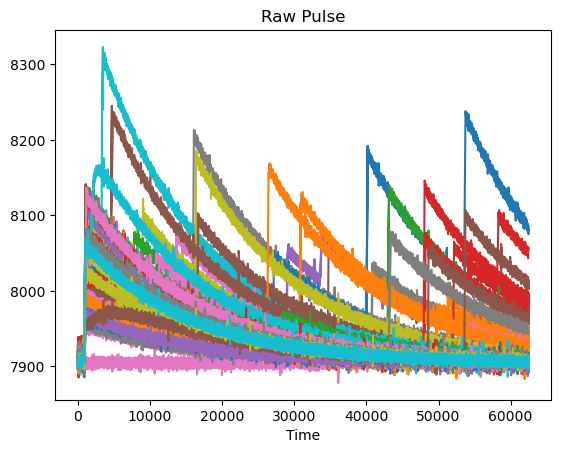

In [58]:
#Plot the raw 
first_pulse = f['raw_data'][0] 
plt.figure()

for i in range(0, 100):
    plt.plot(f['raw_data'][i])
    plt.xlabel('Time')
    plt.title('Raw Pulse')

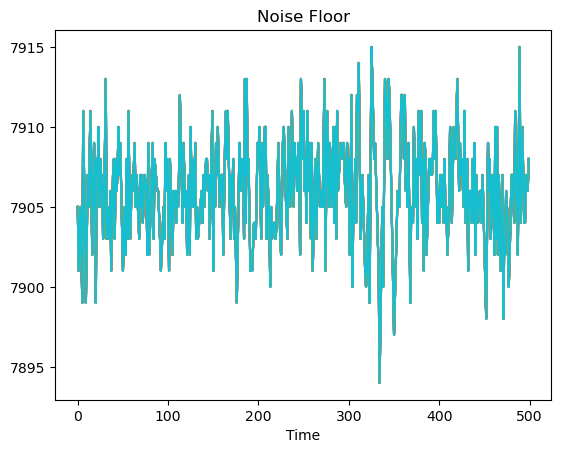

In [63]:
#Background subtraction for the raw data
for i in range(0, 100):
    Floor = f["raw_data"][i][0:500]
plt.figure()
for i in range(0, 10):
    plt.plot(Floor)
    plt.title("Noise Floor")
    plt.xlabel("Time")
    Floor_mu = np.mean(Floor)
    BkgSubtractedPulses = f["raw_data"][i] - Floor_mu

Text(0.5, 0, 'Time')

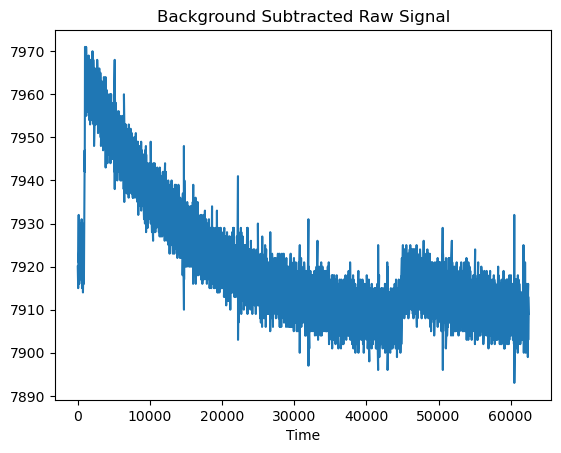

In [64]:
#Plot background subtracted data
plt.figure()
plt.plot(first_pulse)
plt.title("Background Subtracted Raw Signal")
plt.xlabel("Time")

In [16]:
#define an exponential function 
def exp_func(x, a, b, c):
    #returns a times e^(-b times a) + c
    return a * np.exp(-b * x) + c

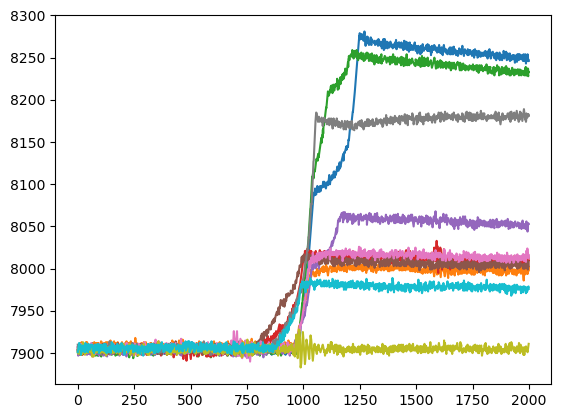

In [54]:
"'Plotting the rise of a bunch of data to see possible pileup'"
plt.figure()

for i in range (0, 10):
    plt.plot(f["raw_data"][i][:2000])

#This was finding the start of the exponential, but we want to fit the whole curve. 
#y_max = np.amax(first_pulse)
# x_top = np.where(first_pulse == y_max)
# exp_start = int(x_top[0])
# print(y_max, exp_start)
# type(exp_start)

C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


[3.59184907e+02 6.91949863e-05 2.85461504e+00]


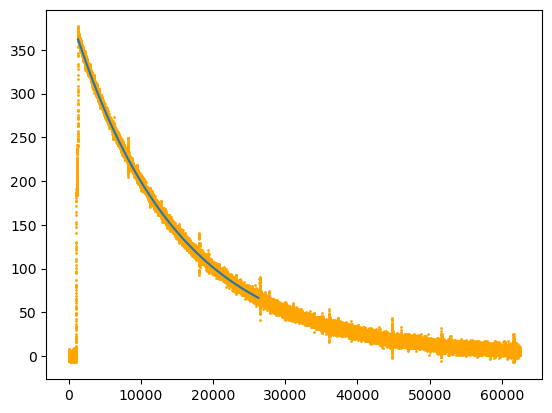

In [14]:
#fit the background subtracted raw data to the exp function
endfit = 25000
x = np.arange(0,endfit)
popt, pcov = curve_fit(exp_func, x, first_pulse[exp_start:exp_start+endfit])
print(popt)

#plot fitted exponential against bkg sub raw data
plt.figure()
plt.plot(range(exp_start,exp_start+len(exp_func(x, *popt))),exp_func(x, *popt))
plt.scatter(np.arange(0,len(first_pulse)),first_pulse, s=1, color='orange')

In [15]:
#find the decay constant
tau = 1/popt[1]
print("The decay constant, tau, is", tau)

The decay constant, tau, is 14451.914127061134


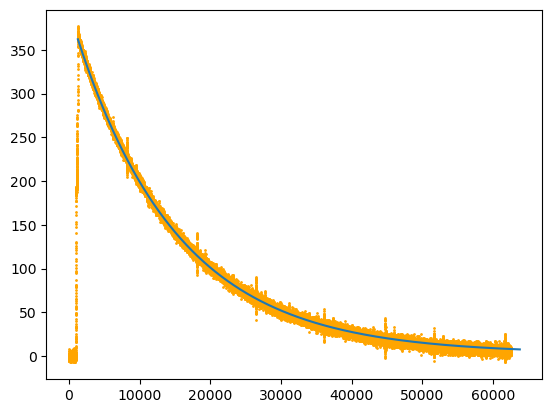

In [16]:
#extrapolate the fit for the whole range of data
raw_range = np.arange(0,len(first_pulse))
exp_pulse = exp_func(raw_range, *popt)
plt.figure()
plt.plot(np.arange(exp_start,exp_start+len(first_pulse)), exp_pulse)
plt.scatter(np.arange(0,len(first_pulse)),first_pulse, s=1, color='orange')

In [71]:
#Variables for the convolution functions
T1 = exp_start + tau
T2 = len(exp_pulse) - 0.04*len(exp_pulse) - tau
t = np.linspace(0,len(exp_pulse)-1,len(exp_pulse),dtype=int) # has length 62500
print(T1, T2)
print(t[:100])

15722.914127061134 45548.085872938864
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [77]:

truncated_ramp = lambda t, T1: np.concatenate((t[:np.argmin(np.abs(t-T1))+1], 
                                               np.zeros(len(t)-np.argmin(np.abs(t-T1))-1)))
moving_average = lambda t, T2: np.concatenate((np.ones(np.argmin(np.abs(t-T2))+1), 
                                               np.zeros(len(t)-np.argmin(np.abs(t-T2))-1)))
def trap_conv(t, T1, T2, tau):
    #linear combination of truncated ramp and moving average 
    h1 = truncated_ramp(t, T1)
    h2 = moving_average(t, T2)
    h1_t_T2 = np.roll(h1, T2)
    h2_t_T1 = np.roll(h2, T1)
    return h1 + tau*h2 + (T1 - tau)*h2_t_T1 - h1_t_T2
    
plt.figure()
plt.plot(trap_conv(t, T1, T2, tau))


TypeError: slice indices must be integers or None or have an __index__ method

<Figure size 640x480 with 0 Axes>

In [ ]:
conv_signal = np.convolve(exp_pulse, trap_conv(t, T1, T2, tau))
plt.figure()
plt.plot(conv_signal)
plt.title("Trapezoidal Pulse")
